<a href="https://colab.research.google.com/github/cosmo3769/keras.io_examples/blob/main/natural%20language%20processing/Text_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing text data

* Text Standardization - converting uppercase to lowercase in text or removing punctuation.
* Text splitting (tokenization) - split text into units(tokens), such as characters, words or group of words.
* Vocabulary indexing - Convert each such token into a numerical vector. Usually, it involves first indexing all the tokens in the data.
* Using the TextVectorization layer


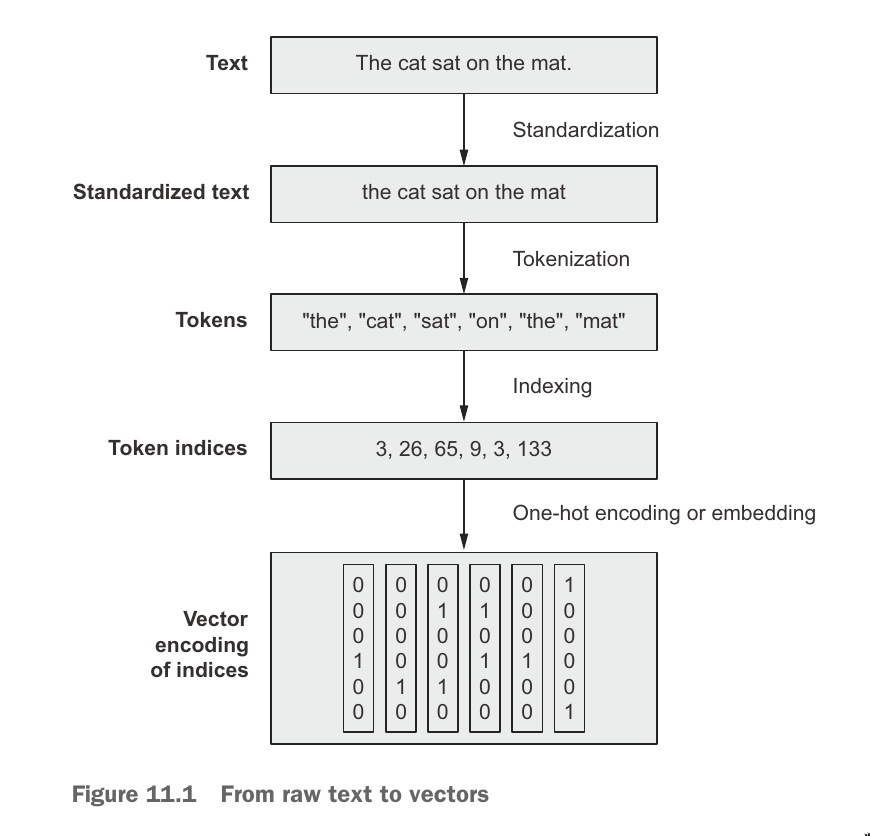

## Text Standardization

It is a basic form of feature engineering that aims to erase encoding differences that you don’t want your model to have to deal with. 

Techniques:

* convert to lowercase and remove punctuation characters.
* convert special characters to a standard form, such as replacing “é” with “e,” “æ” with “ae,” and so on.
* Stemming: converting variations of a term into a single shared representation. (turning “caught” and “been catching” into “[catch]” or “cats” into “[cat]”)

This will ensure that your model will require less training data and will generalize better—it won’t need abundant examples of both “Sunset” and “sunset” to learn that they mean the same thing, and it will be able to make sense of “México” even if it has only seen “mexico” in its training set.

standardization may also erase some amount of information, so always keep the context in mind: for instance, if you’re writing a model that extracts questions from interview articles, it should definitely treat “?” as a separate token instead of dropping it, because it’s a useful signal for this specific task.

## Tokenization (Text Splitting)

Break standardized text into units to vectorize(tokens).

* Word-level tokenization: tokens are space-separated (or punctuation- separated) substrings. We can further split word into sub-words.(staring into star+ing, called into call+ed)
* N-gram tokenization: tokens are groups of N consecutive words.(“the cat” or “he was” would be 2-gram tokens, called bigrams).
* Character-level tokenization: each character is its own token. You can use it in specialized contexts like text generation or speech recognition.

Text-processing models: 

* sequence models: this cares about word order, It uses word-level tokenization.
* bag-of-words models: treat input words as a set, discards their original order. It uses N-gram tokenization.

N-grams are a way to artificially inject a small amount of local word order information into the model.


## Vocabulary Indexing

Build an index of all terms found in the training data (the “vocabulary”), and assign a unique integer to each entry in the vocabulary.

Convert that integer into a vector encoding that can be processed by a
neural network, like a one-hot vector.

NOTE: It's common to restrict vocabulary to the most common words because indexing those rare terms would result in an excessively large feature space,
where most features would have almost no information content.

* OOV Token: "here was a word we did not recognize". given index 1 when encoding words to integers.(OOV index) When decoding integer to words, this index 1 changes to "[UNK]".
* Mask Token: "ignore me, I’m not a word". given index 0. It is used to pad sequence data. If they are two sequences, one longer and one shorter, the shorter sequence needs to be of same length to that of the longer sequence.(Two sequence before padding: [5, 7, 124, 4, 89] and [8, 34, 21], Two sequence after padding: [[5, 7, 124, 4, 89][8, 34, 21, 0, 0]])

## Using the TextVectorization layer

In [ ]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

In [ ]:
vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [ ]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [ ]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


### TextVectorization from keras

* fast and efficient
* can be dropped directly into a `tf.data` pipeline or a Keras model.

By default it uses:

* convert to lowercase and remove punctuation for text standardization.
* split on whitespace for tokenization.

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode="int",
)

#### Custom function for standardization and tokenization

It works on `tf.string` tensors and not regular python strings.

In [ ]:
import re
import string
import tensorflow as tf

def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

To index the vocabulary of a text corpus, just call the `adapt()` method of the layer with a Dataset object that yields strings, or just with a list of Python strings.

In [ ]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
text_vectorization.adapt(dataset)

#### Displaying the vocabulary.

It is useful if you need to convert text encoded as integer sequences back into words.

First two entries in the vocabulary are:

* Mask Token(index 0)
* OOV Token(index 1)

Entries in the vocabulary list are sorted by frequency, so with a real-world dataset, very common words like “the” or “a” would come first.

In [ ]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)


In [ ]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


## Two approaches for representing groups of words: Sets and Sequences

Till now, we know what to encode words into, but the question is: how to encode the way words are woven into sentences: word order.

* set - bag-of-words model(treat text as an unordered set of words)
* sequences - RNNs and Transformers models(take order into account)

#### Preparing the IMDB movie reviews data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  16.1M      0  0:00:04  0:00:04 --:--:-- 18.0M


In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

Dataset split into validation(20% of training data)

In [ ]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

`text_dataset_from_directory`: create a batched Dataset of text and their labels, just as `image_dataset_from_directory` does for image dataset.

In [ ]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


These datasets yield inputs that are TensorFlow `tf.string` tensors and targets that are `int32` tensors encoding the value “0” or “1.”(0 for negative, 1 for positive)

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b"The movie is very lengthy and unfortunately pretty different from the Novel. If you want to see the movie then don't read the novel first as it will shock you. However, cinematography was OK and if you are a person who loves adventure genres which explores Africa then go for it. Acting performances are adequate, however, many important events that were present in the novel are omitted. In the novel, Sir Henry Curtis was in search of his missing brother rather than a lady in search of her father. Gagool was cunning and was killed in the cave whereas here she was shown to be a good person who preferred to stay with the new king.", shape=(), dtype=string)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


## Processing words as a set: The bag-of-words approach

The simplest way to encode a piece of text for processing by a machine learning
model is to discard order and treat it as a set (a “bag”) of tokens. You could either look at individual words (unigrams), or try to recover some local order information by looking at groups of consecutive token (N-grams).

#### Single words (Unigrams) with Binary Encoding 

If you use a bag of single words, the sentence “the cat sat on the mat” becomes
{"cat", "mat", "on", "sat", "the"}. This enconding represents an entire text as a single vector, where each entry is a presence indicator for a given word. Using binary encoding (multi-hot), you’d encode a text as a vector with as many
dimensions as there are words in your vocabulary—with 0s almost everywhere and
some 1s for dimensions that encode words present in the text.

**Preprocessing our datasets with a `TextVectorization` layer**

In [ ]:
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Inspecting the output of our binary unigram dataset**

In [ ]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


**Our model-building utility**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

**Training and testing the binary unigram model**

We call cache() on the datasets to cache them in memory: this way preprocessing is done only once, during the first epoch, and then it will reuse the preprocessed texts for the following epochs. **NOTE**- This can only be done if the data is small enough to fit in memory. 



In [ ]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 12s 19ms/step - loss: 0.4048 - accuracy: 0.8276 - val_loss: 0.2830 - val_accuracy: 0.8886
Epoch 2/10
625/625 [=======================

This gives us a test accuracy of 88.9%. 

#### Bigrams with binary encoding

Discarding word order is very reductive, because even atomic concepts can
be expressed via multiple words: the term “United States” conveys a concept that is quite distinct from the meaning of the words “states” and “united” taken separately.Injecting local order information into bag-of-words representation is necessary to convey the meaning of the words more clearly. With bigrams, our sentence becomes:

{"the", "the cat", "cat", "cat sat", "sat",
"sat on", "on", "on the", "the mat", "mat"}.

**Configuring the TextVectorization layer to return bigrams**

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

**Training and testing the binary bigram model**

In [ ]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 13s 19ms/step - loss: 0.3772 - accuracy: 0.8447 - val_loss: 0.2653 - val_accuracy: 0.9004
Epoch 2/10
625/625 [=====================

This gives us a test accuracy of 89.7%. Improvement by using local word information. 

#### Bigrams with TF-IDF encoding

Add a bit more information to this representation by counting how many
times each word or N-gram occurs, that is to say, by taking the histogram of the words over the text:

{"the": 2, "the cat": 1, "cat": 1, "cat sat": 1, "sat": 1,
"sat on": 1, "on": 1, "on the": 1, "the mat: 1", "mat": 1}

How many times a word occurs in a sample
is critical: any sufficiently long movie review may contain the word “terrible” regardless of sentiment, but a review that contains many instances of the word “terrible” is likely a negative one.



**To count bigram occurrences with the TextVectorization layer:**

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

But counting most frequent words only possess a problem. There are words like "the", "a" which appears the most in any document but adds nothing meaningful to the classification task. It will drown out other meaningful words that will contribute to classification task. If we are taking only count as an account to add information to make classification more accurate then it will fail due to this issue. So what should be done?

We can use normalization. We can normalize word counts by subtracting the mean and dividing by the variance (computed across the entire training dataset). But this causes `sparsity` issue. Most of vectorized sentences is sparse, meaning that it has most zero entity and very few non-zero entity. When we will subtract by mean it will disrupt this sparsity as all the zeroes values get changed. Sparsity is helpful in reducing the computation overload and also helps to reduce the risk of overfitting. So what should be done? We should go for something which uses division to normalize.  

We can use TF-IDF normalization to address this issue: 

TF-IDF normalization stands for `Term Frequency, Inverse Document Frequency`. 

The more a given term appears in a document, the more important that term is for
understanding what the document is about. At the same time, the frequency at which the term appears across all documents in your dataset matters too: terms that appear in almost every document (like “the” or “a”) aren’t particularly informative, while terms that appear only in a small subset of all texts (like “Herzog”) are very distinctive, and thus important. **TF-IDF is a metric that fuses these two ideas. It weights a given term by taking “term frequency,” how many times the term appears in the current document, and dividing it by a measure of “document frequency,” which estimates how often the term comes up across the dataset.**

**Configuring TextVectorization to return TF-IDF-weighted outputs:**

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

**Training and testing the TF-IDF bigram model**

In [ ]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Doing text standardization, splitting, and indexing as
part of the tf.data pipeline is good. But, when exporting a standalone model, we need to ensure that it contains text preprocessing layer to avoid reimplementing text preprocessing always while feeding data. It also avoids discrepancy between the training data and the production data. 

In [ ]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

## Processing words as a sequence: The sequence model approach

We have seen so far that word order is important and manual engineering of
order-based features, such as bigrams, yields a nice accuracy boost. But, the
history of deep learning is that of a move away from manual feature engineering, toward letting models learn their own features from exposure to data alone. This is where sequence model comes. `RNN`, `BRNN`, `1-D Convnet`, `Transformers`. 

### A first practical example

For the given input of sentences, a sentence needs to be vectorized, so all words are converted to integers.

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Next, let's build the model. Convert the integer sequences to vector sequences by using one-hot encoding method(each dimension would represent one
possible term in the vocabulary). And, use BLSTM.

In [ ]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

**Train the model**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

A first observation: this model trains very slowly, especially compared to the lightweight model of the previous section. This is because our inputs are quite large: each input sample is encoded as a matrix of size (600, 20000) (600 words per sample, 20,000 possible words). That’s 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do. Second, the model only gets to 87% test accuracy—it doesn’t perform nearly as well as our (very fast) binary unigram model.

So, one hot encoding was not a good idea. There is a better method called as `word embeddings`.

### Understanding word embeddings

When you encode something via one-hot encoding, you’re making a feature-
engineering decision. You’re injecting into your model a fundamental assumption
about the structure of your feature space. That assumption is that the different tokens you’re encoding are all independent from each other: indeed, one-hot vectors are all orthogonal to one another. And in the case of words, that assumption is clearly wrong. Words form a structured space: they share information with each other. The words “movie” and “film” are interchangeable in most sentences, so the vector that represents “movie” should not be orthogonal to the vector that represents “film”—they should be
the same vector, or close enough.

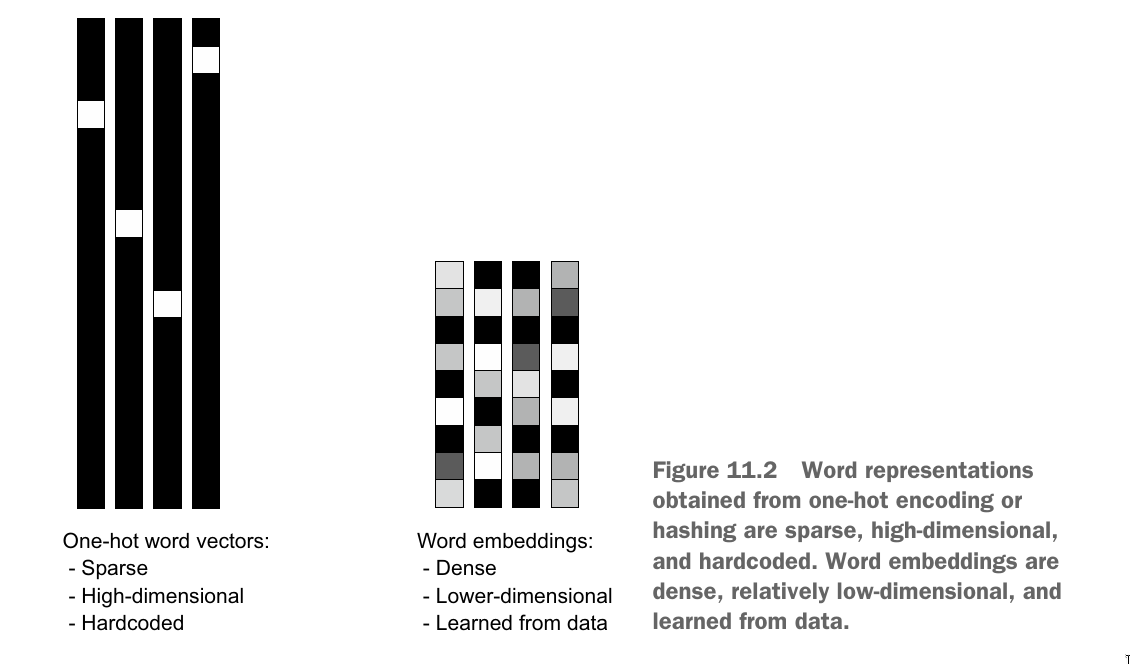

**Word embeddings pack more information into far fewer dimensions.** Similar words are pull closer and different words are pulled apart in an embedding space. 

### Two ways to obtain word embeddings: 

* Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
* Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called
`pretrained word embeddings`.